In [2]:
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.neural_network import MLPClassifier
from six import StringIO
from sklearn.model_selection import train_test_split
import pydot
import pydotplus
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import KBinsDiscretizer
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from graphviz import Source
from sklearn import tree
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import SGDRegressor

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
copied_path = 'drive/MyDrive/FinalDataSet.csv' #remove ‘content/’ from path then use 
data = pd.read_csv(copied_path,dtype={'Sourceid':np.object_})
data = data.drop(['Unnamed: 0'], axis=1)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4,8,9,16,27,28,29,36,38) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
#Change the types
data['year'] = data['year'].apply(lambda x: pd.to_numeric(x, errors='coerce'))
data['issue'] = data['issue'].apply(lambda x: pd.to_numeric(x, errors='coerce'))
data['volume'] = data['volume'].apply(lambda x: pd.to_numeric(x, errors='coerce'))
data = data[(data.doc_type == "Journal") | (data.doc_type == "Conference")]
data['publisher'] = data['publisher'].astype("string")
data['Rank'] = data['Rank'].astype(int)
data['Country'] = data['Country'].astype("string")
data['Region'] = data['Region'].astype("string")
data['Title'] = data['Title'].astype("string")
data['nb_authors'] = data['nb_authors'].astype(int)
data['pages'] = data['pages'].astype(int)
data['year'] = data['year'].astype(int)
data['author1'] = data['author1'].astype("string")
data['index_length'] = data['index_length'].astype(float)
data['first_common'] = data['first_common'].astype("string")
data['second_common'] = data['second_common'].astype("string")
data['third_common'] = data['third_common'].astype("string")
data['fourth_common'] = data['fourth_common'].astype("string")
data['nb_references'] = data['nb_references'].astype(float)
data['Main_fos'] = data['Main_fos'].astype("string")

In [6]:
#drop null values
data = data.dropna(subset=['Main_fos', 'first_common','publisher'])

In [7]:
#create frequency columns
vc_item1_fos = data['Main_fos'].value_counts()
data['fos_pop'] = data['Main_fos'].apply(lambda x: vc_item1_fos[x])

vc_item1_fc = data['first_common'].value_counts()
data['fc_pop'] = data['first_common'].apply(lambda x: vc_item1_fc[x])

In [8]:
### Doctype as dummy
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse=False)
data.iloc[:,5]=enc.fit_transform(data[["doc_type"]])[:,0]
data['doc_type'] = data['doc_type'].astype(int)

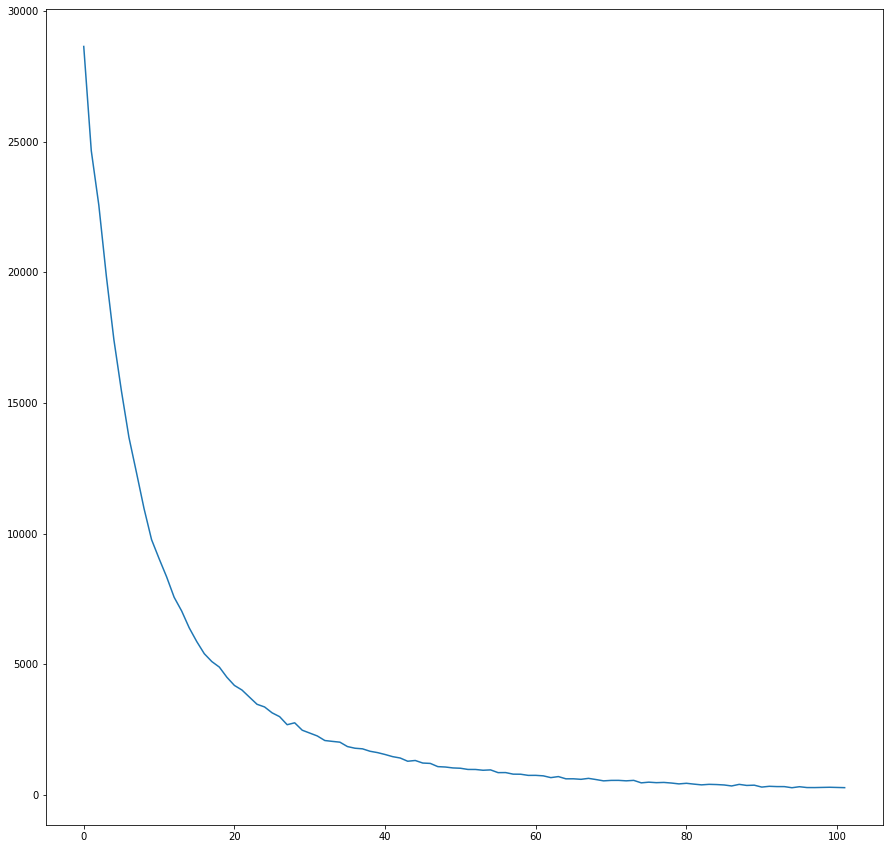

In [9]:
data.n_citation.value_counts()[:100].sort_index().plot(kind="line", figsize = (15,15))

# **Cleaning**

In [10]:
col_data = data[['year', 'n_citation', 'doc_type','volume', 'issue','H index','Total Refs.',
       'Country', 'pages','nb_authors','index_length', 'fc_pop', 'nb_references',
       'fos_pop']]

In [11]:
#Replacing NaN values with median
median = col_data.loc[col_data['issue']<100000, 'issue'].median()
col_data["issue"] = np.where(col_data["issue"] >100000, median,col_data['issue'])
col_data['issue'] = col_data['issue'].fillna(col_data['issue'].median())

median = col_data.loc[col_data['volume']<100000, 'volume'].median()
col_data["volume"] = np.where(col_data["volume"] >100000, median,col_data['volume'])
col_data['volume'] = col_data['volume'].fillna(col_data['volume'].median())

median = col_data.loc[col_data['nb_references']<100000, 'nb_references'].median()
col_data["nb_references"] = np.where(col_data["nb_references"] >100000, median,col_data['nb_references'])
col_data['nb_references'] = col_data['nb_references'].fillna(col_data['nb_references'].median())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [12]:
#Get country dummies to make it usable
country_dummies = col_data.Country.str.get_dummies()
all_df = [col_data,country_dummies]
data_dummies = pd.concat(all_df, axis=1)
data_dummies.head()

,year,n_citation,doc_type,volume,issue,H index,Total Refs.,Country,pages,nb_authors,index_length,fc_pop,nb_references,fos_pop,Australia,Austria,Brazil,Canada,Chile,China,Czech Republic,Denmark,Egypt,France,Germany,Hong Kong,Hungary,India,Indonesia,Ireland,Italy,Japan,Netherlands,Poland,Portugal,Russian Federation,Serbia,Singapore,Slovenia,South Africa,South Korea,Spain,Sweden,Switzerland,Taiwan,Turkey,Ukraine,United Arab Emirates,United Kingdom,United States
0,1995,22276,0,20.0,3.0,152.0,4124.0,Netherlands,25,2,122.0,1,3.0,47,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2009,20162,0,25.0,16.0,390.0,29619.0,United Kingdom,2,9,89.0,14,8.0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,2003,19392,0,3.0,3.0,230.0,13524.0,United States,30,3,120.0,376,11.0,87,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,1993,13116,0,14.0,11.0,188.0,14925.0,United States,17,13,96.0,13,2.0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,1998,11964,0,16.0,8.0,236.0,9052.0,United States,8,1,89.0,44,3.0,59,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [13]:
#delete Country column
display(data_dummies.head())
data_dummies=data_dummies.drop("Country",1)
col_data=col_data.drop("Country",1)

,year,n_citation,doc_type,volume,issue,H index,Total Refs.,Country,pages,nb_authors,index_length,fc_pop,nb_references,fos_pop,Australia,Austria,Brazil,Canada,Chile,China,Czech Republic,Denmark,Egypt,France,Germany,Hong Kong,Hungary,India,Indonesia,Ireland,Italy,Japan,Netherlands,Poland,Portugal,Russian Federation,Serbia,Singapore,Slovenia,South Africa,South Korea,Spain,Sweden,Switzerland,Taiwan,Turkey,Ukraine,United Arab Emirates,United Kingdom,United States
0,1995,22276,0,20.0,3.0,152.0,4124.0,Netherlands,25,2,122.0,1,3.0,47,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2009,20162,0,25.0,16.0,390.0,29619.0,United Kingdom,2,9,89.0,14,8.0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,2003,19392,0,3.0,3.0,230.0,13524.0,United States,30,3,120.0,376,11.0,87,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,1993,13116,0,14.0,11.0,188.0,14925.0,United States,17,13,96.0,13,2.0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,1998,11964,0,16.0,8.0,236.0,9052.0,United States,8,1,89.0,44,3.0,59,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


# **Dataset for "classification" model**

In [14]:
#Creation of the categories for n_citation                                        
est = KBinsDiscretizer(n_bins=20, encode='ordinal', strategy='kmeans')
data_dummies= data_dummies.reset_index(drop=True)
lab = data_dummies['n_citation'].to_numpy().reshape(-1,1)
est.fit(lab)
KB_cat = est.transform(lab)  ###Transformation en catégories
cat_dtf = pd.DataFrame(KB_cat,columns=['KB_cat'])
data_dummies['KB_cat'] = cat_dtf['KB_cat']
class_data_dummies=data_dummies.drop("n_citation",1)
np.set_printoptions(suppress=True)
est.bin_edges_

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:184: ConvergenceWarning: Number of distinct clusters (19) found smaller than n_clusters (20). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:197: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)


array([array([    0.        ,    19.77180889,    57.81678752,   125.15723889,
         239.94760246,   438.12939903,   774.31366122,  1289.6016295 ,
        2039.57467532,  3128.92664093,  4764.75437202,  6770.80392157,
        8705.08333333,  9996.25      , 10989.25      , 12363.25      ,
       16254.        , 19777.        , 21219.        , 22276.        ])],
      dtype=object)

# **Dataset for "quantitative" model (eg.:regression)**

In [15]:
#Dataset with n_citation kept
qtt_data_dummies=data_dummies.drop("KB_cat",1)

# **Dataset for regression (dummies of publisher) => Abandonned because of memory shortage**

In [ ]:
col_data_reg = data[['year', 'n_citation', 'doc_type','volume', 'issue','H index','Total Refs.',
       'Country', 'pages','nb_authors','index_length', 'fc_pop', 'nb_references',
       'fos_pop','publisher']]


In [ ]:
median = col_data_reg.loc[col_data_reg['issue']<100000, 'issue'].median()
col_data_reg["issue"] = np.where(col_data_reg["issue"] >100000, median,col_data_reg['issue'])
col_data_reg['issue'] = col_data_reg['issue'].fillna(col_data_reg['issue'].median())

median = col_data_reg.loc[col_data_reg['volume']<100000, 'volume'].median()
col_data_reg["volume"] = np.where(col_data_reg["volume"] >100000, median,col_data_reg['volume'])
col_data_reg['volume'] = col_data_reg['volume'].fillna(col_data_reg['volume'].median())

median = col_data_reg.loc[col_data_reg['nb_references']<100000, 'nb_references'].median()
col_data_reg["nb_references"] = np.where(col_data_reg["nb_references"] >100000, median,col_data_reg['nb_references'])
col_data['nb_references'] = col_data_reg['nb_references'].fillna(col_data_reg['nb_references'].median())

In [ ]:
publisher_count = col_data_reg['publisher'].value_counts()


publisher_count = publisher_count.to_frame()

publisher_count['pub_name']= publisher_count.index

vc_pub = col_data_reg['publisher'].value_counts()
col_data_reg['pub_num'] = col_data_reg['publisher'].apply(lambda x: vc_pub[x])

col_data_final = col_data_reg[col_data_reg['pub_num'] > 100]
col_data_final.info()
publisher_dummies_reg = col_data_final.publisher.str.get_dummies()

In [ ]:
country_dummies_reg = col_data_final.Country.str.get_dummies()
country_dummies_reg.head()

all_df_reg = [col_data_final,country_dummies_reg,publisher_dummies_reg]
data_dummies_reg = pd.concat(all_df_reg, axis=1)
data_dummies_reg = data_dummies_reg.drop(['Country','publisher'],axis=1) #UTILISER DATA_DUMMIES_REG
data_dummies_reg.head()

# **Classification**

In [16]:
# Prepare data (training and testing sets)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
dataframe = class_data_dummies.sample(n=351588)

X = dataframe.drop("KB_cat", 1)
y = dataframe["KB_cat"]

#Normalization
scaler = MinMaxScaler()
v = scaler.fit_transform(X)
X = pd.DataFrame(v,columns=X.columns)


#order of variable = important
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.20, random_state=1) # random state for repeatability

# **KNN model**

In [ ]:
###Use KNN
KNN = KNeighborsClassifier(n_neighbors = 119,weights='distance')

# Train
KNN.fit(Xtrain, ytrain)

# Predict
predict_KNN = KNN.predict(Xtest)

print("Accuracy:", accuracy_score(ytest, predict_KNN))

In [ ]:
dfp = pd.DataFrame({'Actual': ytest, 'Predicted': predict_KNN})
dfp.value_counts()

# **KNN With GridSearch**


In [ ]:
###Chosing the right metaparameters with Gridsearch

metaparameters_KNN = {"n_neighbors": range(150,160),"weights": 'distance'}

# initialize the model
KNN = KNeighborsClassifier(random_state=1)
best_KNN = GridSearchCV(KNN,metaparameters_KNN,cv=3)
best_KNN.fit(Xtrain, ytrain)

print(best_knn.best_params_)
# Test the model
print("Accuracy:", accuracy_score(ytest, best_KNN.predict(Xtest)))

# **Decision tree**

In [ ]:
### Use DT
DT = DecisionTreeClassifier(random_state = 1,max_leaf_nodes=148,max_depth=50)
DT.fit(Xtrain, ytrain)

#Predict
prediction = DT.predict(Xtest)

# Test the model
print("Accuracy:",accuracy_score(ytest, prediction))

In [ ]:
list(zip(DT.feature_importances_,X)) #Importance of the features

In [ ]:
dfp = pd.DataFrame({'Actual': ytest, 'Predicted': prediction})
dfp.value_counts()

In [ ]:
###Import PNG
dot_data = StringIO()
tree.export_graphviz(DT, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = X.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
graph.write_png('DecisionTree.png')

In [51]:
DT.score(X, y, sample_weight=None)

0.703619008612353

# **Decision Tree with GridSearch**

In [ ]:
###Chosing the right metaparameters with Gridsearch

metaparameters_DT = {"max_depth": [40,50],"max_leaf_nodes":[1000,2000]}

# initialize the model

DT = KNeighborsClassifier()
best_DT = GridSearchCV(DT,metaparameters_DT,cv=5)
best_DT.fit(Xtrain, ytrain)

print(best_DT.best_params_)  
# Test the model
print("Accuracy:", accuracy_score(ytest, best_DT.predict(Xtest)))

# **Random Forest**

In [60]:
###Model used
RF =RandomForestClassifier(max_depth=35,max_leaf_nodes=1900, random_state=1,n_estimators=300)
RF.fit(Xtrain, ytrain)

# Test the model
print("Accuracy:",accuracy_score(ytest, RF.predict(Xtest)))

0.6868369407548565


In [ ]:
list(zip(RF.feature_importances_,X))

[(0.09349548810761757, 'year'),
 (0.07170915951635824, 'doc_type'),
 (0.04103780081996245, 'volume'),
 (0.02496790805981094, 'issue'),
 (0.2993951460908072, 'H index'),
 (0.0817815431046296, 'Total Refs.'),
 (0.1692509560357583, 'pages'),
 (0.014802426852883337, 'nb_authors'),
 (0.03219475898308939, 'index_length'),
 (0.003813458289194864, 'fc_pop'),
 (0.10481724699012396, 'nb_references'),
 (0.006248822927352581, 'fos_pop'),
 (3.2894893429895383e-06, 'Australia'),
 (7.031213708591408e-06, 'Austria'),
 (0.0, 'Brazil'),
 (0.0, 'Canada'),
 (1.5236867899963919e-05, 'Chile'),
 (0.0, 'China'),
 (6.523706323660007e-06, 'Czech Republic'),
 (5.911011999745438e-06, 'Denmark'),
 (0.0005047703973939074, 'Egypt'),
 (5.43967976163886e-05, 'France'),
 (0.0019376756099111535, 'Germany'),
 (0.0, 'Hong Kong'),
 (0.0, 'Hungary'),
 (9.007140109389792e-06, 'India'),
 (0.0, 'Indonesia'),
 (0.0002966357565339071, 'Ireland'),
 (0.0, 'Italy'),
 (0.011376532220378203, 'Japan'),
 (0.0072775532348221495, 'Nether

# **ANN**

In [61]:
#Train the model
ANN =MLPClassifier(random_state=1)
ANN.fit(Xtrain, ytrain)

#Test the model
print("Accuracy:",accuracy_score(ytest, ANN.predict(Xtest)))

0.6794561847606587


In [ ]:
parameters_ANN = {"hidden_layer_sizes": [(5,5,5),(5,5,5)]} # test all value between 1000 and 1004 --> increase range as much as possible
#With GridSearch
ANN = MLPClassifier()
best_ANN = GridSearchCV(ANN,parameters_ANN,cv=5)
best_ANN.fit(Xtrain, ytrain)

print(best_ANN.best_params_) 

#Accuracy
print("Test error:", accuracy_score(ytest, best_ANN.predict(Xtest)))

# **SVM**

In [ ]:
###SVM
SVM =make_pipeline(StandardScaler(), SVC(gamma='auto'))
SVM.fit(Xtrain, ytrain)

# Test the model
print("Accuracy:",accuracy_score(ytest, SVM.predict(Xtest)))

# **Regression**

In [17]:
# Prepare data (training and testing sets)

regdata = qtt_data_dummies.sample(n = 351588)

In [18]:
###Normalizing
scaler = MinMaxScaler()
regdata = scaler.fit_transform(regdata)

In [ ]:
regdata = pd.DataFrame(regdata,columns=qtt_data_dummies.columns)
regdata.head()

MSE: 3.164955776922481e-05
R2: 0.039205699467649624


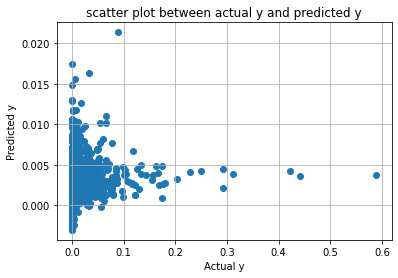

In [21]:
###Prepare train test
x = regdata.drop(['n_citation'],axis=1)
y = regdata['n_citation']

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.22,shuffle=False, random_state=1)

#Linear Model
LM = linear_model.LinearRegression(copy_X=True)
LM.fit(x_train, y_train)

#Prediction
y_pred = LM.predict(x_test)

#Plot
print("MSE:",mean_squared_error(y_test, y_pred))
print("R2:",r2_score(y_test, y_pred))
plt.scatter(y_test,LM.predict(x_test))
plt.grid()
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.title('scatter plot between actual y and predicted y')
plt.show()


In [23]:
for i in range(len(list(zip(LM.coef_, x)))):#Coefficients
  print(list(zip(LM.coef_, x))[i])

(-0.006098121304919311, 'year')
(-0.00023693601559645217, 'doc_type')
(-0.0017830956892736106, 'volume')
(0.0033061004058718337, 'issue')
(0.010488802313133129, 'H index')
(-0.005467446739532767, 'Total Refs.')
(0.015564034664121046, 'pages')
(0.027377476797096314, 'nb_authors')
(0.002103763120995937, 'index_length')
(1.7237494684260837e-05, 'fc_pop')
(0.0235666537574219, 'nb_references')
(7.479596991953042e-06, 'fos_pop')
(0.0011669483136809323, 'Australia')
(-0.0004437908834382459, 'Austria')
(-1.0213184464813452e-16, 'Brazil')
(-0.0002286392826847256, 'Canada')
(-0.0003164236002909446, 'Chile')
(-0.0003930944527625413, 'China')
(-0.0005344214182006964, 'Czech Republic')
(0.0001812505421421268, 'Denmark')
(-3.0515788682619635e-05, 'Egypt')
(8.626858134013396e-05, 'France')
(0.00010548547371624338, 'Germany')
(4.039469567381218e-05, 'Hong Kong')
(-0.00023550590890251657, 'Hungary')
(0.00015246388750368812, 'India')
(4.94634625605849e-05, 'Indonesia')
(0.00011322130813394983, 'Ireland'

In [24]:
dfp = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
dfp

,Actual,Predicted
274238,0.000000,0.000787
274239,0.002559,0.000721
274240,0.000045,0.000249
274241,0.012166,0.003556
274242,0.000045,0.000981
...,...,...
351583,0.001751,0.002120
351584,0.000494,0.000297
351585,0.000135,0.001581
351586,0.001257,0.002186


MSE: 3.190667747629414e-05
R2: 0.03140024604210523


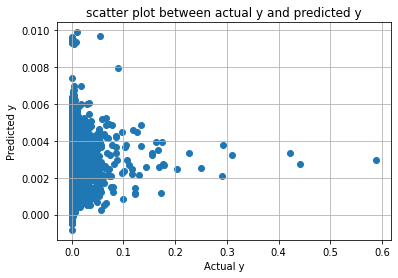

In [26]:
###Prepare train test
x = regdata.drop(['n_citation'],axis=1)
y = regdata['n_citation']

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.22,shuffle=False, random_state=1)

#Linear Model
SGD = SGDRegressor()
SGD.fit(x_train, y_train)

#Prediction
y_pred = SGD.predict(x_test)

#Plot
print("MSE:",mean_squared_error(y_test, y_pred))
print("R2:",r2_score(y_test, y_pred))
plt.scatter(y_test,SGD.predict(x_test))
plt.grid()
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.title('scatter plot between actual y and predicted y')
plt.show()


In [27]:
for i in range(len(list(zip(SGD.coef_, x)))):##Coefficient
  print(list(zip(SGD.coef_, x))[i])

(-0.004541284696340918, 'year')
(-0.00037213579273652535, 'doc_type')
(-0.0012360941476633968, 'volume')
(0.0004343611494194791, 'issue')
(0.009375988886367538, 'H index')
(-0.0011743873859920233, 'Total Refs.')
(0.00012545280569200795, 'pages')
(0.0006204784080263376, 'nb_authors')
(0.0025953986010787524, 'index_length')
(0.00012594789032857994, 'fc_pop')
(0.007116991167015546, 'nb_references')
(0.00018385564986111736, 'fos_pop')
(4.132457244272961e-05, 'Australia')
(1.5526785083907115e-05, 'Austria')
(0.0, 'Brazil')
(-2.258285745048125e-06, 'Canada')
(6.5675622523666275e-06, 'Chile')
(7.580694566165327e-07, 'China')
(-9.544669678382056e-06, 'Czech Republic')
(0.00010375054560160773, 'Denmark')
(0.00025683415224990816, 'Egypt')
(0.0001909043723419068, 'France')
(0.0003236031206597359, 'Germany')
(-7.598914378092977e-07, 'Hong Kong')
(2.109548921498924e-06, 'Hungary')
(1.7062331421030058e-05, 'India')
(-7.993274177478689e-07, 'Indonesia')
(0.0004196637527808608, 'Ireland')
(5.142951988

# **Additional stuff**

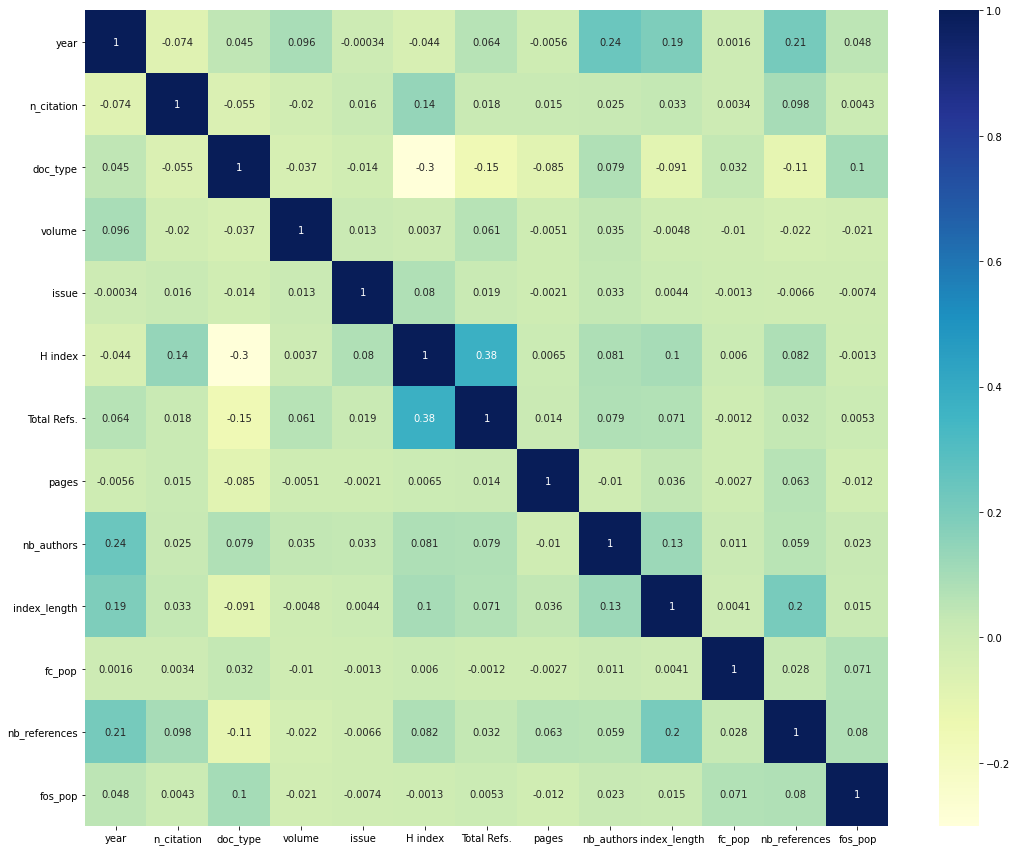

In [28]:
import seaborn as sns
import matplotlib
#Using Pearson Correlation
plt.figure(figsize=(18,15))
cor = col_data.corr()
sns.heatmap(cor, annot=True, cmap="YlGnBu")
plt.show()